# Spam Detection with Python

Objective: 

Build a Spam filter on the UCI dataset (https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) that differentiates between Spam and Non-Spam text messages.




### Imports

In [47]:
import os

#EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Training and Evaluation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valerie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load data

In [5]:
pwd = os.getcwd()
messages = pd.read_csv(pwd + '/SMSSpamCollection.csv', sep='\t', names = ['label', 'message'])
print(len(messages))

5572


## 1. Exploratory Data Analysis

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [17]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
messages.iloc[50]

label                                                    ham
message    What you thinked about me. First time you saw ...
Name: 50, dtype: object

In [38]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [39]:
#what possibly seperates spam from not-spam messages
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [19]:
#create new feature length
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Outlier detection

<AxesSubplot:ylabel='Frequency'>

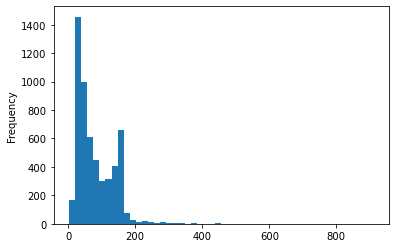

In [42]:
messages['length'].plot.hist(bins=50)

In [43]:
#check for outliers
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [28]:
messages[messages['length'] >= 500]['message'].count()

6

In [30]:
messages[messages['length'] == 910]['message']

1085    For me the love should start with attraction.i...
Name: message, dtype: object

In [29]:
#nothing suspicious with the longer messages
[messages['length'] >= 500]['message']

1085    For me the love should start with attraction.i...
1579    How to Make a girl Happy? It's not at all diff...
1863    The last thing i ever wanted to do was hurt yo...
2158    Sad story of a Man - Last week was my b'day. M...
2434    Indians r poor but India is not a poor country...
2849    Sad story of a Man - Last week was my b'day. M...
Name: message, dtype: object

In [21]:
messages.groupby('label')['length'].mean()

label
ham      71.482487
spam    138.670683
Name: length, dtype: float64

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

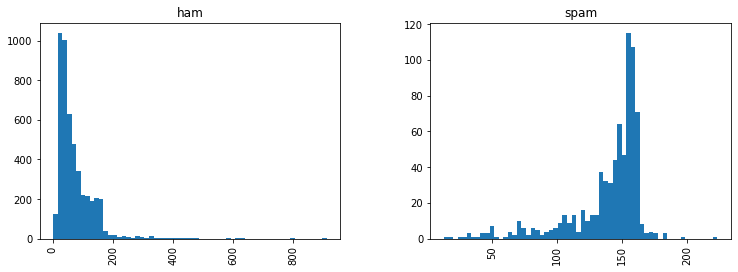

In [49]:
messages.hist(column='length',by='label',bins=60,figsize=(12,4))

Conclusion:
- length distinguishing feature between spam and not-spam
- spam messages have much more characters!

# 2. Text Pre-processing

Bag of Words to convert text corpus into numerical matrix, so that ML model can use it as training data
- CountVectorizer to transform corpus into amatrix
- normalize the counts using the TfidfTransformer

First step: Data Cleaning

To Do:

- use list comprehension to check if character is not in string.punctuation and remove stopwords
- join clean elements in a list


In [33]:
#apply this function later to each message
def text_process(mess):
    '''
    1. remove punc
    2. remove stop words
    3. return list of clean text words
    '''
    
    nopunc = [char for char in mess if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    

In [62]:
messages.head(5)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [34]:
#get list of tokens
#removes stopwords
messages['message'].head(5).apply(text_process)
#function works well

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

To Do:
- apply Tokenizer later to all messages at step Vectorization

### Vectorization

We now have text messages as lists of tokens

To Do:
- convert each message into a vector that ML algorithms can understand and work with
- unse CountVectorizer() to get matrix of token  where each column represents one message, each row represents a word


Three steps using the bag-of-words model:

1. Count how many times a word occurs in each message (term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [35]:
# analyser is the predefined function
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [36]:
#creates a very larga matrix
print(len(bow_transformer.vocabulary_))

11425


In [38]:
# take one sample text message, get its bow count as a vector, put into use the bow_transformer
example_m = messages['message'][3]
print(example_m)

U dun say so early hor... U c already then say...


In [39]:
bow_example = bow_transformer.transform([example_m])
print(bow_example)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [40]:
bow_example.shape

(1, 11425)

In [41]:
#check which words appear twice in message
bow_transformer.get_feature_names()[9554]

'say'

Apply Bag of Words to entire corpus

In [43]:
messages_bow = bow_transformer.transform(messages['message'])

In [44]:
# bag of words count for entire corpus is a larga sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)

Shape of Sparse Matrix:  (5572, 11425)


In [45]:
#check amount of non zero occurences
messages_bow.nnz

50548

In [46]:
#compare number of non zero messages versus actual total number of messages
#how many zeroes are there in your actual matrix?
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


### Tf-idf

After counting comes Tf-idf -> term weight and normalization

To Do:
- get messages represented as numerical vectors to train the spam classifier
-  transform wordcount into Tf-idf to get term frequency - inversee document frequency relationship for the messages

In [50]:
#makes instance and fit it to bag of words
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [51]:
#how does it look like for a single message
#weight value for each of these words
tfidf_example = tfidf_transformer.transform(bow_example)
print(tfidf_example)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


In [52]:
# check document frequency of a particular word
tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

8.527076498901426

Apply Tf-idf to entire corpus

In [53]:
# convert entire bow corpus into tfidf corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)

## 3. Train and evaluate a model

To Do:
- build pipeline to preprocess and vectorize data and train a model in one step
- start with Naive Bayes Classifier



In [61]:
#pass in a list of every step to perform on the data
pipeline_nb = Pipeline([
                     ('bow', CountVectorizer(analyzer=text_process)),
                     ('tfidf', TfidfTransformer()),
                     ('classifier', MultinomialNB())
                ])

In [55]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(messages['message'], messages['label'],test_size=0.3)

In [62]:
#fit and train the data, pipeline does all the preporcessing
pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f9f8814bee0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [63]:
predictions = pipeline_nb.predict(X_test)

In [59]:
#classification report on predictions
print(classification_report(y_test,predictions))
#not bad for a first try

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1457
        spam       1.00      0.69      0.82       215

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672



To Do:

Train a different Classifier

In [64]:
pipeline_rf = Pipeline([
                     ('bow', CountVectorizer(analyzer=text_process)),
                     ('tfidf', TfidfTransformer()),
                     ('classifier', RandomForestClassifier())
                ])

In [65]:
pipeline_rf.fit(X_train, y_train)
predictions = pipeline_rf.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1457
        spam       0.99      0.81      0.89       215

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.94      1672
weighted avg       0.98      0.97      0.97      1672



### Results
- RandomForestClassifier() performs slighty better on the classification task than the Naive Bayes Classifier